# Twitter USA Airline Sentiment Analysis Using Keras and RNNs

## Problem

The problem explored through this implementation is related to sentiment analysis and Natural Language Processing (NLP) which is a field in AI where the machine processes and develops an understanding of the human language. One common modality used in this purpose, and for this project, is text. 
Sentiment analysis for this project involves classifying the meaning of that text into positive, negative or neutral classes. This project will tackle this problem using tweets about different US Airlines. 

## Purpose of this project

Social Media such as Facebook or Twitter are now part of most people's lives and represent a primary medium through which they express their opinions regarding personal life, politics and experiences with businesses such as recent interactions or purchases. Working on solutions to understand customer feedback and sentiment can represent a valuable advantage in business strategy improvement. 

This project will explore and compare six different implementations of Recurrent Neural Networks (RNNs) and their performance in classifying negative, neutral and positive tweets. This will help us determining what implementation would be the most efficient and appropriate to the dataset on this classification task.

RNNs are very popular in the field of NLP due to their ability to process sequential data and create state containing information about what the network has learned so far. Indeed, RNNs work by creating loops between each neuron in the network and this characteristic makes it specifically efficient for sequential data such as text. This is why we believe choosing this solution is efficient for this specific text classification task.

###### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

## The Data

The dataset used is from a CSV file downloaded from Kaggle, called “Twitter US Airline Sentiment” and will be sent along with this project. It contains 14,640 rows and 15 columns. The tweets, about several US airlines, were scraped in 2015 from Twitter. Each tweet was classified as positive, neutral or negative - called airline_sentiment - assigned with a confidence score label - called 'airline_sentiment_confidence' - and got a main reason as for the tweet was classify as negative - called 'negativereason' - . 

Import data from the CSV file 'Tweets.csv' provided with this Jupyter file:

In [2]:
# Import twitter data
df = pd.read_csv("/Users/Didie/Desktop/Tweets.csv")

In [3]:
# Look at first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Number of rows and columns of data
df.shape

(14640, 15)

## Data Analysis, Cleaning and Proccessing

In [5]:
# Count number of missing values in each column
# Note that only missing values in columns we will later drop
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

As part of the data cleaning, we only need the two columns that contains the tweet text and sentiment label. In the following steps, we will:
- analyse the data further
- convert values to integers to process the data 
- split the colmns we need, text and label and assign them to X and Y

In [6]:
# Showing the 2 columns we need, that contains the tweet text and sentiment label
df[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [7]:
# Count number of each type of tweet
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

From this result, we can see there are almost three times as many negative tweets than neutral or positive. From this, we could first assume that people are more keen on being vocal if something is wrong.

In [8]:
# Convert to integers values
df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', 1)
df['airline_sentiment'] = df['airline_sentiment'].replace('negative', 0)
df['airline_sentiment'] = df['airline_sentiment'].replace('positive', 2)

In [37]:
# Split into text and label
X = df['text'] # data
y = df['airline_sentiment'] # labels

Please note that the tweets themselves are not being cleaned. So, any twitter handles, special characters, and punctuation are not removed. The reason for that is because the RNN that will follow would automatically learn these variations and patterns.

### Preprocess data¶


An important part of the process is tokenizing and vectorising the text.
- Tokenization is the process of converting sentences into words.
- Vectorization is converting the words into a vector of integers. Each unique word in the dataset would have its own integer representation and each tweet would then be represented as a vector with each element containing an integer that can be mapped to a specific word.

To do this work, we use Keras' Tokenizer and text_to_word_sequence.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [11]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

In [12]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1

In [13]:
# integer encode everything
sequences = t.texts_to_sequences(X)

In [14]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

Let's see how many words are contained within the longest tweet:

In [15]:
tweet_num = max_tweet()
tweet_num

30

The longest tweet has 30 words.

Because tweets can have different lengths this can result in the vector lengths to be also mismatched.
As a solution, now that we know that the longest tweet has a length of 30 words, then we can pad each vector with 0’s such that they all have the same dimensions:

In [16]:
# each review has a different number of words, so pad sequence with 0's
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

This step is to convert the sentiment labels to be one-hot encoded. Meaning that our response for each tweet is now a row vector with three elements. It contains a 1 in the column corresponding to its sentiment label and 0’s elsewhere.

In [17]:
# Convert labels
labels = to_categorical(np.asarray(y))

Lastly, we create a training and test set, giving 20% to the test set and the remaining 80% to the training set:

In [18]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [19]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


### Pre-trained word embedding¶


In that part, we use GloVe. 
The appropriate file, the 100 dimensional version (embedding dimension), was sent with the data set, so it's easy to put it directly on your machine.

Global Vectors for Word Representation(GloVe) is a model used for word embedding and is an extension of the popular word2vec. This model creates a word-context matrix or a measure to indicate that some specific words are more likely to be seen than others for a certain context. 

For this project, we used the pre-trained words vector 100 to give us a large set of 400k words vocabulary.

In [20]:
# load the whole embedding into memory
# Using 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('/Users/Didie/Desktop/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [22]:
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False because we already used a pre-trained word embedding, 
#input lengh is the lengh of the longest tweet, 30 in the variable tweet_num
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

# Neural Networks Implementation

In this part of the work, we will build and compare six different Recurrent Neural Networks.

For each of the following models, the inputs are the training data. There are 30 features in each observation, corresponding to each word in the tweet. If a word is missing, it will be replaced with a 0.

A dense layer finishes each model with three nodes because there are three possible labels: positive, neutral or negative. 
Because it’s a classification problem, we use accuracy as a metric.
Each model is compiled with an Adam optimizer and a categorical crossentropy.

As part of the metrics and obervations, we also implemented a clock to see and compare how long each model training takes.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
import time

## Model 1: Simple RNN LSTM Model with regularization, increase dimensionality¶


For this first model, in addition to the specified embedding and dense softmax layer, we also use one single LSTM layer of an output dimension of 156. We then increase the dimensionality from the embedding layer that is 100.

A regularization with dropout, at 0.2, and recurrent dropout, at 0.5, is added.

Following that step, the model is trained on 100 epochs and a 256 batch size.

In [24]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(156, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm (LSTM)                  (None, 156)               160368    
_________________________________________________________________
dense (Dense)                (None, 3)                 471       
Total params: 1,737,739
Trainable params: 160,839
Non-trainable params: 1,576,900
_________________________________________________________________


In [25]:
start = time.time()

In [26]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 12s 250ms/step - loss: 0.9085 - acc: 0.5833 - val_loss: 0.8293 - val_acc: 0.6300
Epoch 2/100
37/37 [==============================] - 12s 333ms/step - loss: 0.7936 - acc: 0.6610 - val_loss: 0.7236 - val_acc: 0.7315
Epoch 3/100
37/37 [==============================] - 12s 336ms/step - loss: 0.6791 - acc: 0.7287 - val_loss: 0.6517 - val_acc: 0.7324
Epoch 4/100
37/37 [==============================] - 11s 287ms/step - loss: 0.6345 - acc: 0.7429 - val_loss: 0.5920 - val_acc: 0.7618
Epoch 5/100
37/37 [==============================] - 8s 205ms/step - loss: 0.6123 - acc: 0.7463 - val_loss: 0.5877 - val_acc: 0.7631
Epoch 6/100
37/37 [==============================] - 7s 200ms/step - loss: 0.5852 - acc: 0.7652 - val_loss: 0.5629 - val_acc: 0.7708
Epoch 7/100
37/37 [==============================] - 7s 201ms/step - loss: 0.5691 - acc: 0.7677 - val_loss: 0.5515 - val_acc: 0.7746
Epoch 8/100
37/37 [==============================] - 7s 199ms/ste

In [27]:
FirsttModelTimeOfExecution = time.time()-start

In [28]:
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%d:%d" % (hour, minutes, seconds) 

In [29]:
print("\nTime of execution = ", convert(FirsttModelTimeOfExecution)) 


Time of execution =  0:12:46


In [30]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9462
Testing Accuracy:  0.7920


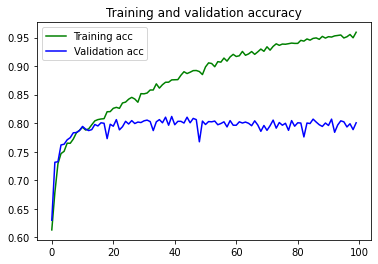

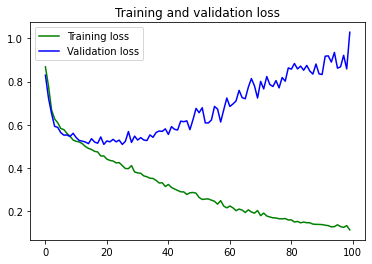

In [31]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [33]:
# Get predicted values
y_pred = lstm_mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [34]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [35]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[1711  126   33]
 [ 248  332   34]
 [ 117   51  276]]
Normalized confusion matrix
[[0.91 0.07 0.02]
 [0.4  0.54 0.06]
 [0.26 0.11 0.62]]


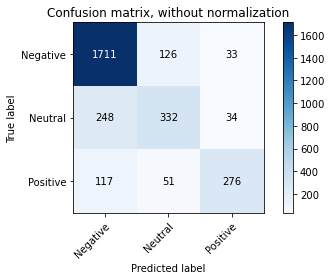

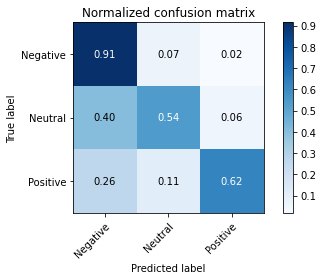

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()




##### Because the model demonstrated clearly an overfit , in the following models, we experiment with modifying the LSTM, dropout and recurrent_dropout.




#### Second setting for model 1 to rectify overfit:

In [442]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(50, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_50 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 153       
Total params: 1,607,253
Trainable params: 30,353
Non-trainable params: 1,576,900
_________________________________________________________________


In [443]:
startbis = time.time()

In [444]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 6s 96ms/step - loss: 0.9459 - acc: 0.5946 - val_loss: 0.8443 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 3s 85ms/step - loss: 0.8248 - acc: 0.6321 - val_loss: 0.7903 - val_acc: 0.6709
Epoch 3/100
37/37 [==============================] - 3s 93ms/step - loss: 0.7525 - acc: 0.6821 - val_loss: 0.6861 - val_acc: 0.7209
Epoch 4/100
37/37 [==============================] - 4s 102ms/step - loss: 0.6741 - acc: 0.7184 - val_loss: 0.6232 - val_acc: 0.7482
Epoch 5/100
37/37 [==============================] - 3s 77ms/step - loss: 0.6450 - acc: 0.7375 - val_loss: 0.5950 - val_acc: 0.7606
Epoch 6/100
37/37 [==============================] - 3s 71ms/step - loss: 0.6107 - acc: 0.7488 - val_loss: 0.5926 - val_acc: 0.7559
Epoch 7/100
37/37 [==============================] - 3s 74ms/step - loss: 0.5822 - acc: 0.7586 - val_loss: 0.5867 - val_acc: 0.7657
Epoch 8/100
37/37 [==============================] - 3s 71ms/step - loss: 0

In [445]:
BisFirsttModelTimeOfExecution = time.time()-startbis

In [446]:
print("\nTime of execution = ", convert(BisFirsttModelTimeOfExecution)) 


Time of execution =  0:5:37


In [447]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8958
Testing Accuracy:  0.7982


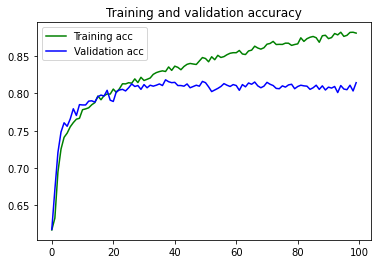

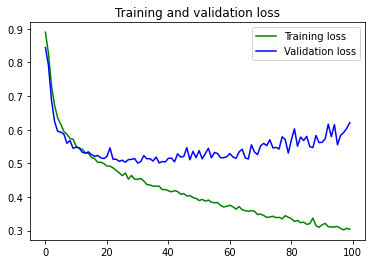

In [448]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Obervation for model 1:

We experiemented with two different settings for this model. When we realise the first setting made the model overfit by a lot when the number of LSTM units was high, we modified the setting decreasing the LSTM. This helped with reducing the overfit and improved the accuracy. However, the overfit is still important and seems to start a little before the 20th epoch without reaching a plateau.

The model achieves an accuracy of around 79% and does its best job at classifying negative tweets.

# Model 2: LSTM with different regularization, reduce dimensionality¶


In [433]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(15, 
               dropout = 0.2, 
               recurrent_dropout = 0.8))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_49 (LSTM)               (None, 15)                6960      
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 48        
Total params: 1,583,908
Trainable params: 7,008
Non-trainable params: 1,576,900
_________________________________________________________________


In [434]:
start2 = time.time()

In [435]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 5s 70ms/step - loss: 1.0692 - acc: 0.4255 - val_loss: 0.9079 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 2s 46ms/step - loss: 0.8988 - acc: 0.6176 - val_loss: 0.8695 - val_acc: 0.6176
Epoch 3/100
37/37 [==============================] - 2s 46ms/step - loss: 0.8528 - acc: 0.6236 - val_loss: 0.8532 - val_acc: 0.6176
Epoch 4/100
37/37 [==============================] - 2s 46ms/step - loss: 0.8483 - acc: 0.6232 - val_loss: 0.8437 - val_acc: 0.6176
Epoch 5/100
37/37 [==============================] - 2s 45ms/step - loss: 0.8270 - acc: 0.6360 - val_loss: 0.8204 - val_acc: 0.6462
Epoch 6/100
37/37 [==============================] - 2s 45ms/step - loss: 0.8269 - acc: 0.6409 - val_loss: 0.8110 - val_acc: 0.6594
Epoch 7/100
37/37 [==============================] - 2s 45ms/step - loss: 0.7728 - acc: 0.6675 - val_loss: 0.7470 - val_acc: 0.7017
Epoch 8/100
37/37 [==============================] - 2s 46ms/step - loss: 0.

In [436]:
SecondtModelTimeOfExecution = time.time()-start2

In [437]:
print("Time of execution = ", convert(SecondtModelTimeOfExecution)) 

Time of execution =  0:3:32


In [438]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8388
Testing Accuracy:  0.7958


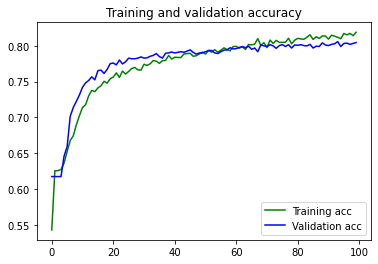

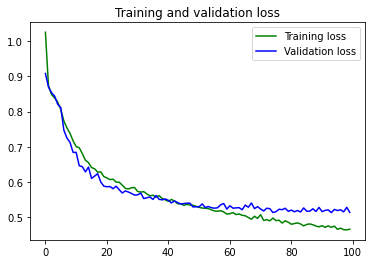

In [439]:
# Plot train/test loss and accuracy
acc = hist_2.history['acc']
val_acc = hist_2.history['val_acc']
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [440]:
# Get predicted values
y_pred = lstm_mod2.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1671  143   56]
 [ 216  343   55]
 [  74   54  316]]
Normalized confusion matrix
[[0.89 0.08 0.03]
 [0.35 0.56 0.09]
 [0.17 0.12 0.71]]


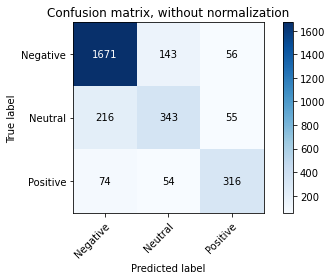

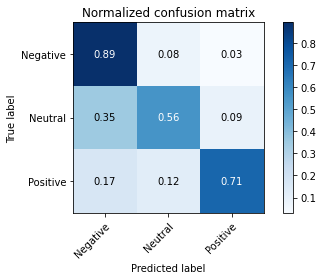

In [441]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Obervation for model 2:

This model is very similar to model 1. However, in order to observe how the model performs in comparison with the last one, we decrease the LSTM and increase the recurrent_dropout. 
It was observed that decreasing the LSTM helps with overfitting. However, keeping the LSTM to a certain high (not below 13 in that case) was important to maintain an accuracy of higher than 79% while reducing overfitting (the model seems to start overfitting arounf the 50th epoch), which can be considered as an improvement in comparison with the last model 1.

Regarding the performance on prediction, we can see that the model does its best job at classifying negative tweets, as did model 1 and, with normalization, the model also performs well at classifying positive tweets. In that matter, model 1 and model 2 provide rather similar results.

# Model 3: LSTM Layer Stacking


Increasing the complexity, this third model adds a second LSTM layer. The first layer has 50 units, the second 30. The dropout in increases to 0.5 as the recurrent_dropout is increased to 0.9.

In [499]:
# LSTM Model
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(LSTM(50, 
               dropout = 0.5, 
               recurrent_dropout = 0.9,
                 return_sequences = True))
model_3.add(LSTM(30,
                dropout = 0.5,
                recurrent_dropout = 0.9))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [500]:
model_3.summary()


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_61 (LSTM)               (None, 30, 50)            30200     
_________________________________________________________________
lstm_62 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 93        
Total params: 1,616,913
Trainable params: 40,013
Non-trainable params: 1,576,900
_________________________________________________________________


We observe that by using layer stacking, we were able to increase the number of trainable parameters.

In [501]:
start3 = time.time()

In [502]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 11s 148ms/step - loss: 0.9428 - acc: 0.5809 - val_loss: 0.8532 - val_acc: 0.6329
Epoch 2/100
37/37 [==============================] - 4s 113ms/step - loss: 0.8360 - acc: 0.6445 - val_loss: 0.8447 - val_acc: 0.6522
Epoch 3/100
37/37 [==============================] - 4s 115ms/step - loss: 0.8137 - acc: 0.6599 - val_loss: 0.7668 - val_acc: 0.6936
Epoch 4/100
37/37 [==============================] - 5s 125ms/step - loss: 0.7836 - acc: 0.6751 - val_loss: 0.7667 - val_acc: 0.7034
Epoch 5/100
37/37 [==============================] - 5s 130ms/step - loss: 0.7592 - acc: 0.6915 - val_loss: 0.7514 - val_acc: 0.7273
Epoch 6/100
37/37 [==============================] - 5s 138ms/step - loss: 0.7468 - acc: 0.6961 - val_loss: 0.6963 - val_acc: 0.7307
Epoch 7/100
37/37 [==============================] - 5s 131ms/step - loss: 0.7257 - acc: 0.7010 - val_loss: 0.6640 - val_acc: 0.7465
Epoch 8/100
37/37 [==============================] - 6s 151ms/step -

In [503]:
ThirdtModelTimeOfExecution = time.time()-start3

In [504]:
print("Time of execution = ", convert(ThirdtModelTimeOfExecution)) 

Time of execution =  0:9:36


In [505]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8438
Testing Accuracy:  0.8067


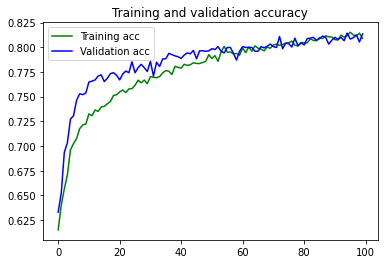

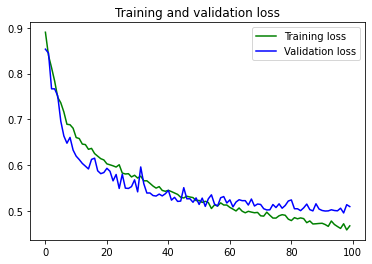

In [506]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [507]:
# Get predicted values
y_pred = model_3.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1698  122   50]
 [ 221  333   60]
 [  73   40  331]]
Normalized confusion matrix
[[0.91 0.07 0.03]
 [0.36 0.54 0.1 ]
 [0.16 0.09 0.75]]


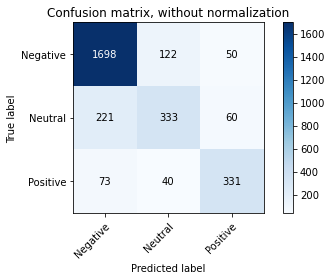

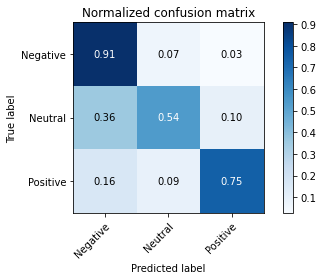

In [508]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Obervation for model 3:

This third model has experiemented with different LSTM, dropout and recurrent_dropout before being presented with the ones above, acheving a better accuracy of 80%. 
Stacking the layers helps with adding more units in the LSTM, increasing the number of trainable parameters while improving slightly the accuracy and decreasing overfitting. However, the model doesn't achieve a performance higher than 80% and the classification performance shown in the confusion matrix is very similar to the first and second model.

# Model 4: GRU Layer Stacking¶

For this fourth model, we are going to experiment with the gated recurrent unit (GRU). GRU is similar to LSTM but work in a simpler way. 
This experiment will allow us to compare its performance with the models before.

In [106]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(50, 
               dropout = 0.5, 
               recurrent_dropout = 0.9,
                 return_sequences = True))
model_4.add(GRU(30,
                dropout = 0.5,
                recurrent_dropout = 0.9))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [107]:
model_4.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_20 (GRU)                 (None, 30, 50)            22800     
_________________________________________________________________
gru_21 (GRU)                 (None, 30)                7380      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 93        
Total params: 1,607,173
Trainable params: 30,273
Non-trainable params: 1,576,900
_________________________________________________________________


In [108]:
start4 = time.time()

In [109]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 9s 121ms/step - loss: 1.0035 - acc: 0.5527 - val_loss: 0.9029 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 3s 94ms/step - loss: 0.8699 - acc: 0.6318 - val_loss: 0.8980 - val_acc: 0.6176
Epoch 3/100
37/37 [==============================] - 4s 104ms/step - loss: 0.8598 - acc: 0.6316 - val_loss: 0.9075 - val_acc: 0.6176
Epoch 4/100
37/37 [==============================] - 3s 93ms/step - loss: 0.8584 - acc: 0.6249 - val_loss: 0.8937 - val_acc: 0.6283
Epoch 5/100
37/37 [==============================] - 4s 95ms/step - loss: 0.8408 - acc: 0.6401 - val_loss: 0.8788 - val_acc: 0.6449
Epoch 6/100
37/37 [==============================] - 3s 93ms/step - loss: 0.8433 - acc: 0.6445 - val_loss: 0.8442 - val_acc: 0.6564
Epoch 7/100
37/37 [==============================] - 4s 95ms/step - loss: 0.8237 - acc: 0.6487 - val_loss: 0.8213 - val_acc: 0.6573
Epoch 8/100
37/37 [==============================] - 4s 96ms/step - loss: 

In [110]:
FourthModelTimeOfExecution = time.time()-start4
print("Time of execution = ", convert(FourthModelTimeOfExecution)) 

Time of execution =  0:7:9


In [111]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8335
Testing Accuracy:  0.7992


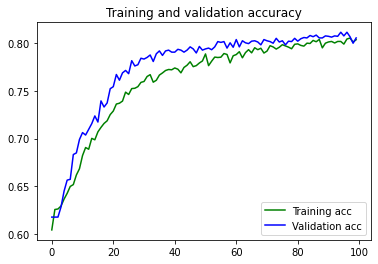

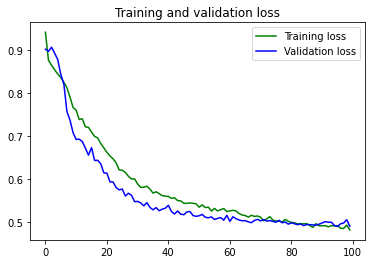

In [112]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
# Get predicted values
y_pred = model_4.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1673  140   57]
 [ 207  352   55]
 [  76   53  315]]
Normalized confusion matrix
[[0.89 0.07 0.03]
 [0.34 0.57 0.09]
 [0.17 0.12 0.71]]


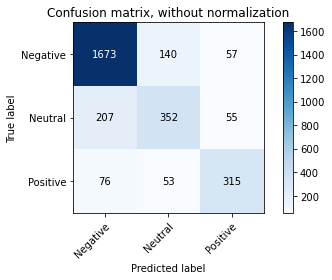

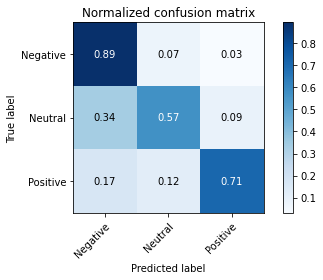

In [114]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Obervation for model 4:

On this fourth model, we used GRU with the same settings as for model 3. We notice that the number of trainable parameters is reduced in comparison to model 3 using LSTM. 
The time for training is shorter than model 3 but the accuracy is slightly lower. 

Regarding the performance of the model from the confusion matrix, it seems like it does a very slightly better job at classifying neutral tweets but performs slightly worse on negative and positive tweets.

## Model 5: GRU with Different Regularization and Increased Dimension

After comparing a model using LSTM and GRU with the same setting, let's try to get a better performance using GRU by modifying the number of GRU, dropout and recurrent_dropout, increasing the complexity of the model.

In [397]:
model_5 = Sequential()
model_5.add(embedding_layer)
model_5.add(GRU(100, 
               dropout = 0.5, 
               recurrent_dropout = 0.8,
                 return_sequences = True))
model_5.add(GRU(70,
                dropout = 0.5,
                recurrent_dropout = 0.8))
model_5.add(Dense(3, activation='softmax'))
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [398]:
model_5.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_88 (GRU)                 (None, 30, 100)           60600     
_________________________________________________________________
gru_89 (GRU)                 (None, 70)                36120     
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 213       
Total params: 1,673,833
Trainable params: 96,933
Non-trainable params: 1,576,900
_________________________________________________________________


In [399]:
start5 = time.time()

In [400]:
history_5 = model_5.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 17s 316ms/step - loss: 0.9487 - acc: 0.5991 - val_loss: 0.8696 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 10s 263ms/step - loss: 0.8451 - acc: 0.6351 - val_loss: 0.8433 - val_acc: 0.6462
Epoch 3/100
37/37 [==============================] - 11s 307ms/step - loss: 0.8154 - acc: 0.6566 - val_loss: 0.7843 - val_acc: 0.6803
Epoch 4/100
37/37 [==============================] - 12s 336ms/step - loss: 0.7767 - acc: 0.6733 - val_loss: 0.7156 - val_acc: 0.7064
Epoch 5/100
37/37 [==============================] - 11s 299ms/step - loss: 0.7540 - acc: 0.6768 - val_loss: 0.7056 - val_acc: 0.7098
Epoch 6/100
37/37 [==============================] - 8s 209ms/step - loss: 0.7351 - acc: 0.6943 - val_loss: 0.6822 - val_acc: 0.7222
Epoch 7/100
37/37 [==============================] - 7s 195ms/step - loss: 0.7262 - acc: 0.7017 - val_loss: 0.6711 - val_acc: 0.7290
Epoch 8/100
37/37 [==============================] - 7s 189ms/st

In [401]:
FithModelTimeOfExecution = time.time()-start5
print("Time of execution = ", convert(FithModelTimeOfExecution)) 

Time of execution =  0:13:3


In [402]:
loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8560
Testing Accuracy:  0.8019


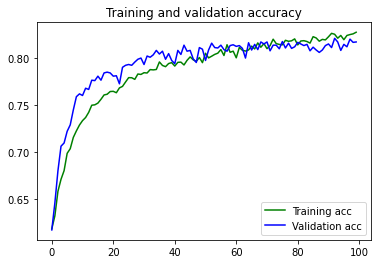

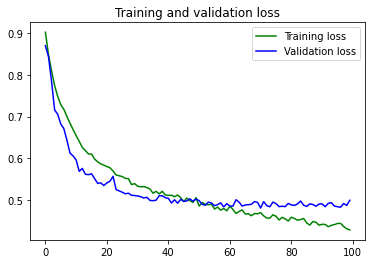

In [403]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [404]:
# Get predicted values
y_pred = model_5.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1688  118   64]
 [ 219  335   60]
 [  69   50  325]]
Normalized confusion matrix
[[0.9  0.06 0.03]
 [0.36 0.55 0.1 ]
 [0.16 0.11 0.73]]


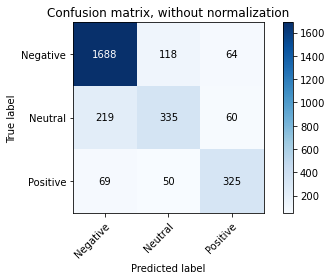

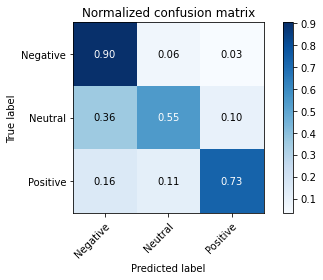

In [405]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Obervation for model 5:

In model 5, we increased the dimensionality by increasing the first GRU to 100 and the second layer to 70. This increase helps in achieving an accuracy of around 80%, a result slightly higher than model 4, while avoiding model overfitting. The fact that the model didn't overfit, even after the increase of GRU and decrease of recurrent_dropout demonstrates that a model using GRU might be less keen on overfitting than one using LSTM.

Regarding the result observed on the confusion matrix, model 5 performed slightly better on negative and positive tweets classification but was less sucessful at classifying neutral tweets than model 4. 

## Model 6: Bidirectional RNN

For our last model, we are going to experiment with a Bidirectional RNN. The difference with other networks is that they usually tend to be unidirectional in the way they process the time steps in a sequential order. Bidirectional RNNs process sequences in both direction which can make it useful to pick up patterns that wouldn’t be captured by unidirectional networks. Therefore, using unidirectional RNNs could improve the performance of a model. 

Let's apply it to this work with 80 units.

In [30]:
from tensorflow.keras.layers import Bidirectional

In [94]:
# Bidirectional RNNs
model_6 = Sequential()
model_6.add(embedding_layer)
model_6.add(Bidirectional(LSTM(80,
                              dropout=0.6,
                              recurrent_dropout=0.9)))
model_6.add(Dense(3,activation='softmax'))
model_6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 160)               115840    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 483       
Total params: 1,693,223
Trainable params: 116,323
Non-trainable params: 1,576,900
_________________________________________________________________


In [95]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [96]:
start6 = time.time()

In [97]:
history_6 = model_6.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 15s 260ms/step - loss: 0.9051 - acc: 0.6032 - val_loss: 0.9037 - val_acc: 0.6359
Epoch 2/100
37/37 [==============================] - 11s 306ms/step - loss: 0.7905 - acc: 0.6689 - val_loss: 0.8582 - val_acc: 0.6837
Epoch 3/100
37/37 [==============================] - 9s 229ms/step - loss: 0.7510 - acc: 0.6950 - val_loss: 0.7294 - val_acc: 0.7277
Epoch 4/100
37/37 [==============================] - 7s 178ms/step - loss: 0.7096 - acc: 0.7156 - val_loss: 0.7949 - val_acc: 0.7234
Epoch 5/100
37/37 [==============================] - 7s 180ms/step - loss: 0.6730 - acc: 0.7217 - val_loss: 0.6807 - val_acc: 0.7490
Epoch 6/100
37/37 [==============================] - 7s 180ms/step - loss: 0.6767 - acc: 0.7191 - val_loss: 0.6315 - val_acc: 0.7559
Epoch 7/100
37/37 [==============================] - 7s 185ms/step - loss: 0.6733 - acc: 0.7144 - val_loss: 0.6606 - val_acc: 0.7525
Epoch 8/100
37/37 [==============================] - 7s 185ms/step 

In [98]:
sixModelTimeOfExecution = time.time()-start6
print("Time of execution = ", convert(sixModelTimeOfExecution)) 

Time of execution =  0:12:35


In [99]:
loss, accuracy = model_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8507
Testing Accuracy:  0.7975


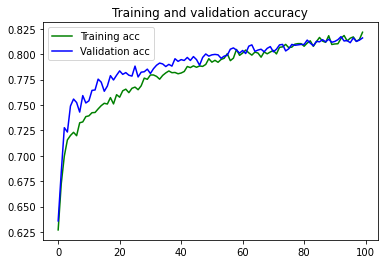

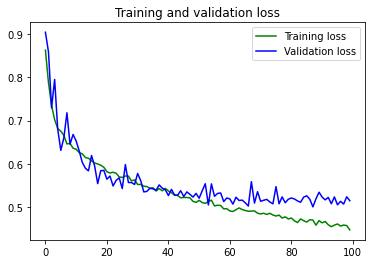

In [100]:
acc = history_6.history['acc']
val_acc = history_6.history['val_acc']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [101]:
# Get predicted values
y_pred = model_6.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1682  136   52]
 [ 215  348   51]
 [  86   53  305]]
Normalized confusion matrix
[[0.9  0.07 0.03]
 [0.35 0.57 0.08]
 [0.19 0.12 0.69]]


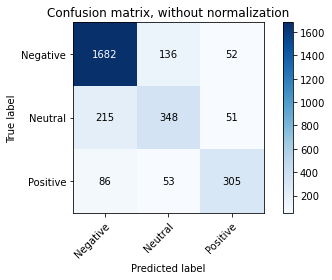

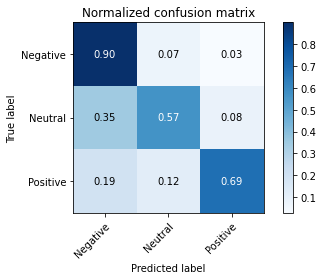

In [102]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Obervation for model 6:

After trying different combinations between the number of units in the bidirectional network, the dropout and reccurent_dropout, we achieve an accuracy of 79%, close to 80% with little overfitting. Something to notice is that, during experimentation with different combinations, this model seems to overfit very quickly. This can be due to the high numbers of trainable paramaters generated. 

On the confusion matrix, the model performs worse at classifying positive tweets in comparison with all the others models previously run. Though, it still did a better job in comparison with some of them at classifying neutral tweets.

# Issues and Conclusion

While building RNN models using LSTM, GRU or even Bidirectionality represent many advantages, it also represents some issues.

We first noticed that the models tend to overfit easily and quickly, especially with a complex dimension architecture. A reduction of the dimension, as well as increasing the dropout and recurrent_dropout, helped with overfitting, but had an impact on the accuracy in the validation set. Therefore when using LSTM, GRU or Bidirectionality, the challenge was to increase the units to the point of getting the best accuracy possible while managing the recurrent_dropout and dropout to handle the overfit.

The models can take between 5 to a little over 10 minutes to train. The time of training increase with a more complex dimension architecture. 

Through all the models implemented and observed we can draw some conclusions on what model to use on this specific dataset to get the best performance in this classification problem. Overall, we saw that the models managed to classify negative tweets best followed by positive tweets. Neutral tweets were the most challenging kind. On a dataset dominated by only negative or positive tweets, models such as model 3 or model 5 can be a good choice. 

However, when the dataset contains neutral tweets, such as the dataset we are using in this work, model 4, using GRU, appears to be a good choice. Indeed, this model achieves one of the best results on neutral tweets classification while also giving good results in negative and positive classification with an accuracy of around 80% and low overfit. 

In this work, we used RNNs to perform a text classification problem. Other solutions are used for similar problem such as Naive Bayes. The issue with that algorithm on a task such as the one in this work is that Naive Bayes doesn't perform very well with a large number of features. Though, popular solutions used on similar datasets include SVM and Random Forest. 
